In [1]:
import pandas as pd
import os
from ast import literal_eval
from tqdm import tqdm
import numpy as np

import seaborn as sns

In [2]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [3]:
DATA_PATH = os.path.join(
   '..', '..', '..', '..', "data", "frameworks_data", 'data_v0.7.1'
)
RELABELED_DATA_PATH = os.path.join(
    DATA_PATH, 'relabeled_data'
)

In [28]:
original_data = pd.read_csv(os.path.join(DATA_PATH, 'full_dataset_with_translations.csv'))
test_data = pd.read_csv(os.path.join(DATA_PATH, 'test_v0.7.1.csv'))

keyword_affected = pd.concat([
    pd.read_csv(os.path.join(RELABELED_DATA_PATH, 'train_0.7.1_keyword_affected_groups_level_3.csv')),
    pd.read_csv(os.path.join(RELABELED_DATA_PATH, 'val_0.7.1_keyword_affected_groups_level_3.csv'))
])
keyword_age = pd.concat([
    pd.read_csv(os.path.join(RELABELED_DATA_PATH, 'train_0.7.1_keyword_age.csv')),
    pd.read_csv(os.path.join(RELABELED_DATA_PATH, 'val_0.7.1_keyword_age.csv'))
])
keyword_gender = pd.concat([
    pd.read_csv(os.path.join(RELABELED_DATA_PATH, 'train_0.7.1_keyword_gender.csv')),
    pd.read_csv(os.path.join(RELABELED_DATA_PATH, 'val_0.7.1_keyword_gender.csv'))
])
keyword_specific_needs_groups = pd.concat([
    pd.read_csv(os.path.join(RELABELED_DATA_PATH, 'train_0.7.1_keyword_specific_needs_groups.csv')),
    pd.read_csv(os.path.join(RELABELED_DATA_PATH, 'val_0.7.1_keyword_specific_needs_groups.csv'))
])

In [5]:
from collections import Counter

important_cols = ['sectors', 'subpillars_2d', 'subpillars_1d']

data_tmp = full_data[important_cols]
n_data = data_tmp.shape[0]

for col in important_cols:
    data_tmp[col] = data_tmp[col].apply(literal_eval)

def flatten(t):
    return [item for sublist in t for item in sublist]

full_tags = flatten(data_tmp.apply(lambda x: x['sectors'] + x['subpillars_2d'] + x['subpillars_1d'], axis=1 ))

sorted_counts = dict(sorted(
    dict(Counter(full_tags)).items(),
    key=lambda item: item[1],
    reverse=True))

Counts = {key: 100*value/n_data for key, value in sorted_counts.items() if key!='NOT_MAPPED' and key!='Cross'}

<ipython-input-5-69eb095592f0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tmp[col] = data_tmp[col].apply(literal_eval)


In [6]:
[key for key, value in Counts.items() if value>15]

['Health', 'Protection', 'Humanitarian Conditions->Living Standards']

In [7]:
f1_scores = []
counts = []

for name in ['results_sectors', 'subpillars_1d_results', 'subpillars_2d_results']:
    df = pd.read_csv(f'../test_predictions/{name}.csv').iloc[:-1]
    for index, row in df.iterrows():
        name_tag = row['names']
        try:
            counts.append(Counts[name_tag])
            f1_scores.append(row['1_f1_score'])
        except Exception as e:
            pass

args_sort_counts = np.argsort(counts)
counts_sorted = [counts[i] for i in args_sort_counts]
f1_scores_sorted = [f1_scores[i] for i in args_sort_counts]

plot_data = pd.DataFrame(
    list(zip(counts_sorted, f1_scores_sorted)),
    columns=['probability of occurence of tag', 'f1 score on test set']
)

In [8]:
plot_data[plot_data['f1 score on test set']<0.4].sort_values(by='probability of occurence of tag', ascending=False)

,probability of occurence of tag,f1 score on test set
37,2.904120,0.375
27,1.496695,0.352
23,1.179502,0.163
22,1.110492,0.321
20,1.067440,0.386
17,0.845848,0.324
16,0.764176,0.336
15,0.600198,0.261
14,0.459645,0.227
13,0.424823,0.251


<ipython-input-9-173e2f7c60fe>:6: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


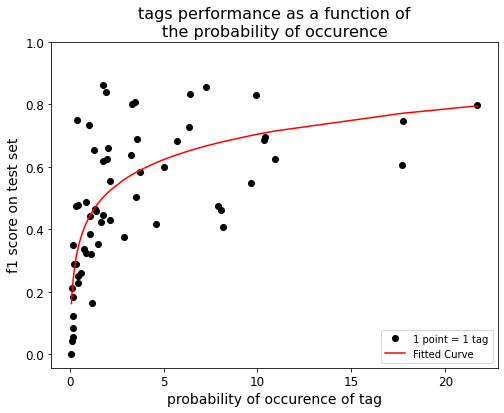

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.log(b * x) + c

x = np.array(counts_sorted)
yn = np.array(f1_scores_sorted)

popt, pcov = curve_fit(func,  x,  yn)

plt.figure(figsize=(8, 6), facecolor='white')
plt.plot(x, yn, 'ko', label="1 point = 1 tag")
plt.plot(x, func(x, *popt), '-r', label="Fitted Curve")
plt.legend(loc='lower right')

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('probability of occurence of tag', fontsize=14)
plt.ylabel('f1 score on test set', fontsize=14)
plt.ylim(top=1)
plt.title('tags performance as a function of\nthe probability of occurence', fontsize=16)
plt.savefig('../../../amld_code/img/tags_score_vs_proba.png', bbox_inches="tight")

In [10]:
"""import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6), facecolor='white')

sns.lmplot(x='probability of occurence of tag', y='f1 score on test set', data=plot_data,
           order=1, scatter_kws={"s": 40}, line_kws={'color': 'cyan'})
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('probability of occurence of tag', fontsize=14)
plt.ylabel('f1 score on test set', fontsize=14)
plt.ylim(top=1)
plt.title('tags performance as a function of\nthe probability of occurence', fontsize=16)
plt.savefig('../../amld_code/img/tags_score_vs_proba.png', bbox_inches="tight")"""

'import matplotlib.pyplot as plt\nimport seaborn as sns\nplt.figure(figsize=(8, 6), facecolor=\'white\')\n\nsns.lmplot(x=\'probability of occurence of tag\', y=\'f1 score on test set\', data=plot_data,\n           order=1, scatter_kws={"s": 40}, line_kws={\'color\': \'cyan\'})\nplt.yticks(fontsize=12)\nplt.xticks(fontsize=12)\nplt.xlabel(\'probability of occurence of tag\', fontsize=14)\nplt.ylabel(\'f1 score on test set\', fontsize=14)\nplt.ylim(top=1)\nplt.title(\'tags performance as a function of\nthe probability of occurence\', fontsize=16)\nplt.savefig(\'../../amld_code/img/tags_score_vs_proba.png\', bbox_inches="tight")'

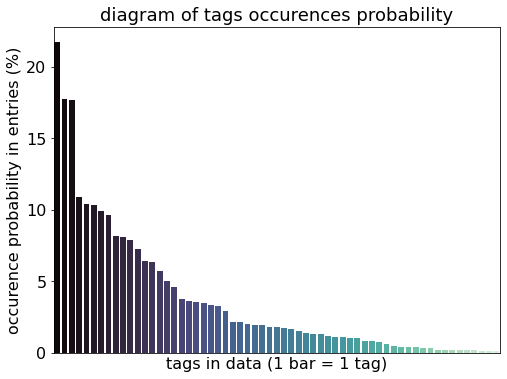

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), facecolor='white')
sns.barplot(x=list(Counts.keys()), y=list(Counts.values()), palette='mako')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.yticks(fontsize=16)
plt.xlabel('tags in data (1 bar = 1 tag)', fontsize=16)
plt.ylabel('occurence probability in entries (%)', fontsize=16)
plt.title('diagram of tags occurences probability', fontsize=18)
plt.savefig('../../../amld_code/img/tags_proba.png', bbox_inches="tight")

In [12]:
{key: 100*value / (97596 + 30653 + 29699) for key, value in dict(Counter(full_data.lang).most_common(3)).items()}

{'en': 61.78995618811254, 'fr': 19.407020031909237, 'es': 18.803023779978222}

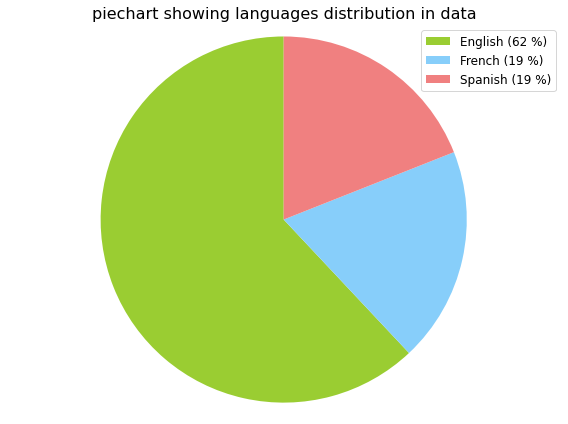

In [13]:
import matplotlib.pyplot as plt
# The slices will be ordered and plotted counter-clockwise.
plt.figure(figsize=(8, 6), facecolor='white')

labels = ['English (62 %)', 'French (19 %)', 'Spanish (19 %)']
sizes = [62, 19, 19]
colors = ['yellowgreen', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best", fontsize=12)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.title('piechart showing languages distribution in data', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.savefig('../../../amld_code/img/piechart_lang.png', bbox_inches="tight")

In [40]:
full_data = pd.merge(
    right=original_data,
    left=keyword_affected,
    on='entry_id',
    how='right'
)
full_data = pd.merge(
    right=full_data,
    left=keyword_age,
    on='entry_id',
    how='right'
)
full_data = pd.merge(
    right=full_data,
    left=keyword_gender,
    on='entry_id',
    how='right'
)
full_data = pd.merge(
    right=full_data,
    left=keyword_specific_needs_groups,
    on='entry_id',
    how='right'
)

In [41]:
full_data = full_data.drop(columns=[
    'age', 'gender', 'specific_needs_groups', 'affected_groups_level_0',
       'affected_groups_level_1', 'affected_groups_level_2',
       'affected_groups_level_3']).\
        rename(columns={'specific_needs_groups_kw': 'specific_needs_groups',
                        'gender_kw_pred': 'gender', 'age_kw_pred': 'age',
                        'affected_groups_level_3_kw': 'affected_groups'
                       })

In [42]:
full_data.columns

Index(['entry_id', 'specific_needs_groups', 'gender', 'age', 'affected_groups',
       'excerpt', 'analysis_framework_id', 'lead_id', 'project_id', 'verified',
       'sectors', 'subpillars_2d', 'subpillars_1d', 'geo_location', 'severity',
       'info_date', 'reliability', 'source_type', 'url', 'website', 'lang',
       'translation_en', 'translation_fr', 'translation_es'],
      dtype='object')

In [43]:
full_data.shape

(158698, 24)

### subpillars setup

In [44]:
sec_tags_mapper = {
    #"Humanitarian Conditions->Number Of People In Need": "Number Tags->Number Of People In Need",
    #"Capacities & Response->Number Of People Reached/Response Gaps": "Number Tags->Capacities & Response Number Of People Reached/Response Gaps",
    #"At Risk->Number Of People At Risk": "Number Tags->Number Of People At Risk",
    #"Displacement->Type/Numbers/Movements": "Number Tags->Displacement Type/Numbers/Movements",
    #"Humanitarian Access->Number Of People Facing Humanitarian Access Constraints/Humanitarian Access Gaps": "Number Tags->Humanitarian Access Number Of People Facing Humanitarian Access Constraints/Humanitarian Access Gaps",
    
    "At Risk->Risk And Vulnerabilities": "Humanitarian Conditions->At Risk",

    "Priority Interventions->Expressed By Humanitarian Staff": "Priorities->Interventions Expressed By Humanitarian Staff",
    "Priority Interventions->Expressed By Population": "Priorities->Interventions Expressed By Population",
    "Priority Needs->Expressed By Humanitarian Staff": "Priorities->Needs Expressed By Humanitarian Staff",
    "Priority Needs->Expressed By Population": "Priorities->Needs Expressed By Population",
}

keys = list(sec_tags_mapper.keys())

def get_new_subpillars(row):
    final_row = []
    for item in row:
        
        if item != 'NOT_MAPPED':
            if item in keys:
                final_row.append(f'subpillars->{sec_tags_mapper[item]}')
            elif 'number' not in item.lower():
                final_row.append(f'subpillars->{item}')

    return list(set(final_row))

for col in ["subpillars_2d", "subpillars_1d"]:
    full_data[f'{col}_modified'] = full_data[col].apply(
        lambda x: get_new_subpillars(literal_eval(x))
    )

full_data['subpillars'] = full_data.apply(
    lambda x: flatten([x[f'{tag}_modified'] for tag in ['subpillars_1d', 'subpillars_2d']]), axis=1
)


In [45]:
full_data['subpillars']

0         [subpillars->Capacities & Response->Internatio...
1         [subpillars->Context->Socio Cultural, subpilla...
2         [subpillars->Shock/Event->Underlying/Aggravati...
3         [subpillars->Humanitarian Access->Physical Con...
4                     [subpillars->Context->Socio Cultural]
                                ...                        
158693                                                   []
158694                                                   []
158695                                                   []
158696                                                   []
158697                                                   []
Name: subpillars, Length: 158698, dtype: object

In [62]:
sorted(list(set(flatten(full_data['subpillars']))))

['subpillars->Capacities & Response->International Response',
 'subpillars->Capacities & Response->Local Response',
 'subpillars->Capacities & Response->National Response',
 'subpillars->Casualties->Dead',
 'subpillars->Casualties->Injured',
 'subpillars->Casualties->Missing',
 'subpillars->Context->Demography',
 'subpillars->Context->Economy',
 'subpillars->Context->Environment',
 'subpillars->Context->Legal & Policy',
 'subpillars->Context->Politics',
 'subpillars->Context->Security & Stability',
 'subpillars->Context->Socio Cultural',
 'subpillars->Covid-19->Cases',
 'subpillars->Covid-19->Contact Tracing',
 'subpillars->Covid-19->Deaths',
 'subpillars->Covid-19->Hospitalization & Care',
 'subpillars->Covid-19->Restriction Measures',
 'subpillars->Covid-19->Testing',
 'subpillars->Covid-19->Vaccination',
 'subpillars->Displacement->Intentions',
 'subpillars->Displacement->Local Integration',
 'subpillars->Displacement->Pull Factors',
 'subpillars->Displacement->Push Factors',
 'subp

### prim_tags setup

In [46]:
all_sectors = [
    "Livelihoods",
    "Food Security",
    "WASH",
    "Logistics",
    "Health",
    "Shelter",
    "Nutrition",
    "Education",
    "Protection",
    "Agriculture",
]

full_data['sectors'] = full_data['sectors'].apply(
        lambda x: [item for item in literal_eval(x) if item != "NOT_MAPPED"]
    )

In [65]:
sectors_tags_part_one = ["Protection", "Food Security", "Health", "Livelihoods"]
sectors_tags_part_two = list(set(all_sectors) - set(sectors_tags_part_one))

full_data["sectors_part_one"] = full_data.sectors.apply(
    lambda x: list(
        set(
            [
                f"first_level_tags->sectors_part_one->{item}"
                for item in x
                if item in sectors_tags_part_one
            ]
        )
    )
)

full_data["sectors_part_two"] = full_data.sectors.apply(
    lambda x: list(
        set(
            [
                f"first_level_tags->sectors_part_two->{item}"
                for item in x
                if item in sectors_tags_part_two
            ]
        )
    )
)

full_data["pillars_1d"] = full_data.subpillars_1d_modified.apply(
    lambda x: list(
        set([f'first_level_tags->pillars_1d->{item.split("->")[1]}' for item in x])
    )
)

full_data["pillars_2d"] = full_data.subpillars_2d_modified.apply(
    lambda x: list(
        set([f'first_level_tags->pillars_2d->{item.split("->")[1]}' for item in x])
    )
)

# add a risk pillar
full_data["at_risk_pillar"] = full_data.subpillars_2d.apply(
    lambda x: list(
        set(
            [
                f"first_level_tags->pillars_2d->At Risk"
                for item in literal_eval(x)
                if "at risk" in item.lower()
            ]
        )
    )
)

# number tags included with pillar 2d because they have a smaller number of pillars compared to pillars 1d
full_data["number_tags"] = full_data.apply(
    lambda x: list(
        set(
            [
                "first_level_tags->pillars_2d->number_tag"
                for item in literal_eval(x.subpillars_2d)
                + literal_eval(x.subpillars_1d)
                if "number" in item.lower()
            ]
        )
    ),
    axis=1,
)


first_level_tags = [
    "sectors_part_one",
    "sectors_part_two",
    "pillars_1d",
    "pillars_2d",
    "number_tags",
    "at_risk_pillar",
]

full_data["first_level_tags"] = full_data.apply(
    lambda x: flatten([x[tag] for tag in first_level_tags]), axis=1
)


In [66]:
full_data["at_risk_pillar"].apply(str).unique()

array(['[]', "['first_level_tags->pillars_2d->At Risk']"], dtype=object)

In [67]:
full_data['first_level_tags']

0         [first_level_tags->sectors_part_one->Health, f...
1         [first_level_tags->sectors_part_two->Education...
2         [first_level_tags->sectors_part_one->Food Secu...
3         [first_level_tags->pillars_1d->Humanitarian Ac...
4                   [first_level_tags->pillars_1d->Context]
                                ...                        
158693                                                   []
158694                                                   []
158695                                                   []
158696                                                   []
158697                                                   []
Name: first_level_tags, Length: 158698, dtype: object

In [68]:
sorted(list(set(flatten(full_data['first_level_tags']))))

['first_level_tags->pillars_1d->Casualties',
 'first_level_tags->pillars_1d->Context',
 'first_level_tags->pillars_1d->Covid-19',
 'first_level_tags->pillars_1d->Displacement',
 'first_level_tags->pillars_1d->Humanitarian Access',
 'first_level_tags->pillars_1d->Information And Communication',
 'first_level_tags->pillars_1d->Shock/Event',
 'first_level_tags->pillars_2d->At Risk',
 'first_level_tags->pillars_2d->Capacities & Response',
 'first_level_tags->pillars_2d->Humanitarian Conditions',
 'first_level_tags->pillars_2d->Impact',
 'first_level_tags->pillars_2d->Priorities',
 'first_level_tags->pillars_2d->number_tag',
 'first_level_tags->sectors_part_one->Food Security',
 'first_level_tags->sectors_part_one->Health',
 'first_level_tags->sectors_part_one->Livelihoods',
 'first_level_tags->sectors_part_one->Protection',
 'first_level_tags->sectors_part_two->Agriculture',
 'first_level_tags->sectors_part_two->Education',
 'first_level_tags->sectors_part_two->Logistics',
 'first_level_ta

### sec tags setup

In [69]:
def custom_eval(x):
    if str(x)=='nan':
        return []
    if str(x)=='[None]':
        return []
    if type(x)==list:
        return x
    else:
        return literal_eval(x)

full_data['demographic_groups'] = full_data.apply(
    lambda x: flatten([custom_eval(x[tag]) for tag in ['age', 'gender']]), axis=1
)

In [70]:
second_level_tags = ['demographic_groups',  'specific_needs_groups', 'severity', 'affected_groups']

for col in second_level_tags:
    full_data[col] = full_data[col].apply(
       lambda x: list(set([f"secondary_tags->{col}->{item}" for item in custom_eval(x) if item!='NOT_MAPPED']))
    )

full_data['second_level_tags'] = full_data.apply(
    lambda x: flatten([x[tag] for tag in second_level_tags]), axis=1
)

In [71]:
full_data['second_level_tags']

0                    [secondary_tags->severity->No problem]
1                         [secondary_tags->severity->Major]
2                    [secondary_tags->severity->Of Concern]
3                                                        []
4                                                        []
                                ...                        
158693                                                   []
158694                                                   []
158695    [secondary_tags->demographic_groups->Children/...
158696    [secondary_tags->demographic_groups->Male, sec...
158697    [secondary_tags->specific_needs_groups->Person...
Name: second_level_tags, Length: 158698, dtype: object

In [72]:
all_tags = ['first_level_tags', 'second_level_tags', 'subpillars']

full_data['target'] = full_data.apply(
    lambda x: flatten([x[tag] for tag in all_tags]), axis=1
)

In [73]:
full_data['target']

0         [first_level_tags->sectors_part_one->Health, f...
1         [first_level_tags->sectors_part_two->Education...
2         [first_level_tags->sectors_part_one->Food Secu...
3         [first_level_tags->pillars_1d->Humanitarian Ac...
4         [first_level_tags->pillars_1d->Context, subpil...
                                ...                        
158693                                                   []
158694                                                   []
158695    [secondary_tags->demographic_groups->Children/...
158696    [secondary_tags->demographic_groups->Male, sec...
158697    [secondary_tags->specific_needs_groups->Person...
Name: target, Length: 158698, dtype: object

In [74]:
all_names = list(set(flatten(full_data['target'])))
split_names = [name.split("->") for name in all_names]

assert np.all([len(name_list) == 3 for name_list in split_names])

In [75]:
len(all_names)

97

In [76]:
def get_first_level_ids():

    assert np.all([len(name_list) == 3 for name_list in split_names])
    final_ids = []

    tag_id = 0
    first_level_names = list(np.unique([name_list[0] for name_list in split_names]))
    for first_level_name in first_level_names:
        first_level_ids = []
        kept_names = [
            name_list[1:]
            for name_list in split_names
            if name_list[0] == first_level_name
        ]
        second_level_names = list(np.unique([name[0] for name in kept_names]))
        for second_level_name in second_level_names:
            second_level_ids = []
            third_level_names = [
                name_list[1]
                for name_list in kept_names
                if name_list[0] == second_level_name
            ]
            for _ in range(len(third_level_names)):
                second_level_ids.append(tag_id)
                tag_id += 1
            first_level_ids.append(second_level_ids)
        final_ids.append(first_level_ids)

    flat_ids = [
        small_list for mid_list in final_ids for small_list in mid_list
    ]
    return final_ids, flat_ids

final_ids, flat_ids = get_first_level_ids()

len(final_ids), len(flat_ids)

(3, 19)

In [77]:
final_ids

[[[0, 1, 2, 3, 4, 5, 6],
  [7, 8, 9, 10, 11, 12],
  [13, 14, 15, 16],
  [17, 18, 19, 20, 21, 22]],
 [[23, 24, 25, 26, 27, 28],
  [29, 30, 31, 32, 33, 34],
  [35, 36, 37, 38, 39],
  [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]],
 [[52, 53, 54],
  [55, 56, 57],
  [58, 59, 60, 61, 62, 63, 64],
  [65, 66, 67, 68, 69, 70, 71],
  [72, 73, 74, 75],
  [76, 77, 78],
  [79, 80, 81, 82],
  [83, 84, 85],
  [86, 87, 88, 89],
  [90, 91, 92, 93],
  [94, 95, 96]]]

In [78]:
flat_ids 

[[0, 1, 2, 3, 4, 5, 6],
 [7, 8, 9, 10, 11, 12],
 [13, 14, 15, 16],
 [17, 18, 19, 20, 21, 22],
 [23, 24, 25, 26, 27, 28],
 [29, 30, 31, 32, 33, 34],
 [35, 36, 37, 38, 39],
 [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51],
 [52, 53, 54],
 [55, 56, 57],
 [58, 59, 60, 61, 62, 63, 64],
 [65, 66, 67, 68, 69, 70, 71],
 [72, 73, 74, 75],
 [76, 77, 78],
 [79, 80, 81, 82],
 [83, 84, 85],
 [86, 87, 88, 89],
 [90, 91, 92, 93],
 [94, 95, 96]]

In [79]:
all_names

['subpillars->Information And Communication->Knowledge And Info Gaps (Hum)',
 'subpillars->Capacities & Response->National Response',
 'secondary_tags->affected_groups->Host',
 'first_level_tags->sectors_part_two->Education',
 'subpillars->Shock/Event->Underlying/Aggravating Factors',
 'subpillars->Covid-19->Testing',
 'subpillars->Context->Economy',
 'subpillars->Covid-19->Hospitalization & Care',
 'subpillars->Priorities->Needs Expressed By Humanitarian Staff',
 'subpillars->Priorities->Interventions Expressed By Humanitarian Staff',
 'first_level_tags->sectors_part_two->Nutrition',
 'subpillars->Displacement->Pull Factors',
 'subpillars->Priorities->Needs Expressed By Population',
 'subpillars->Displacement->Push Factors',
 'subpillars->Shock/Event->Hazard & Threats',
 'secondary_tags->demographic_groups->Male',
 'first_level_tags->sectors_part_one->Health',
 'secondary_tags->specific_needs_groups->Child Head of Household',
 'first_level_tags->pillars_2d->At Risk',
 'subpillars->Cov

In [80]:
list(set([small_list for mid_list in split_names for small_list in mid_list]))

['Information Challenges And Barriers',
 'Agriculture',
 'Humanitarian Conditions',
 'Living Standards',
 'Nutrition',
 'Impact',
 'Injured',
 'Adult (18 to 59 years old)',
 'Food Security',
 'Male',
 'number_tag',
 'Local Integration',
 'Older Persons (60+ years old)',
 'Missing',
 'Physical Constraints',
 'Economy',
 'demographic_groups',
 'Impact On People',
 'Pull Factors',
 'Knowledge And Info Gaps (Pop)',
 'subpillars',
 'Impact On Systems, Services And Networks',
 'Protection',
 'Type And Characteristics',
 'Female Head of Household',
 'Restriction Measures',
 'Communication Means And Preferences',
 'Information And Communication',
 'Infants/Toddlers (<5 years old)',
 'At Risk',
 'Driver/Aggravating Factors',
 'Livelihoods',
 'Pregnant or Lactating Women',
 'Major',
 'secondary_tags',
 'Education',
 'Dead',
 'Hospitalization & Care',
 'Relief To Population',
 'Minorities',
 'Elderly Head of Household',
 'specific_needs_groups',
 'first_level_tags',
 'Of Concern',
 'Intentions',


In [83]:
train_val_full = full_data[~full_data.entry_id.isin(test_data.entry_id)]
train_val_full.columns

Index(['entry_id', 'specific_needs_groups', 'gender', 'age', 'affected_groups',
       'excerpt', 'analysis_framework_id', 'lead_id', 'project_id', 'verified',
       'sectors', 'subpillars_2d', 'subpillars_1d', 'geo_location', 'severity',
       'info_date', 'reliability', 'source_type', 'url', 'website', 'lang',
       'translation_en', 'translation_fr', 'translation_es',
       'subpillars_2d_modified', 'subpillars_1d_modified', 'subpillars',
       'sectors_part_one', 'sectors_part_two', 'pillars_1d', 'pillars_2d',
       'number_tags', 'first_level_tags', 'at_risk_pillar',
       'demographic_groups', 'second_level_tags', 'target'],
      dtype='object')

In [84]:
fr_df = train_val_full[['entry_id', 'translation_fr']]\
        .rename(columns={'translation_fr':'excerpt'}).dropna()
#fr_df['lang'] = 'fr'

en_df = train_val_full[['entry_id', 'translation_en']]\
        .rename(columns={'translation_en':'excerpt'}).dropna()
#en_df['lang'] = 'en'

es_df = train_val_full[['entry_id', 'translation_es']]\
        .rename(columns={'translation_es':'excerpt'}).dropna()
#es_df['lang'] = 'es'

augmented_data = pd.concat([en_df, fr_df, es_df])

In [85]:
augmented_data = pd.merge(
    right=train_val_full.drop(columns=[
        'excerpt', 'translation_en', 'translation_fr', 'translation_es']
                           ),
    left=augmented_data[['entry_id', 'excerpt']],
    on='entry_id',
    how='right'
)

In [86]:
train_val_df = pd.concat([train_val_full, augmented_data])[['excerpt', 'entry_id', 'target']]

In [87]:
train_val_df.to_csv(os.path.join(DATA_PATH, 'new_columns_train_val.csv'), index=None)

In [ ]:
train_val_df.columns

Index(['entry_id', 'specific_needs_groups', 'gender', 'age', 'affected_groups',
       'excerpt', 'analysis_framework_id', 'lead_id', 'project_id', 'verified',
       'sectors', 'subpillars_2d', 'subpillars_1d', 'geo_location', 'severity',
       'info_date', 'reliability', 'source_type', 'url', 'website', 'lang',
       'pillars_1d', 'pillars_2d', 'subpillars', 'secondary_tags',
       'sectors_with_arrows', 'pillars_with_arrows', 'part3_hno'],
      dtype='object')

In [ ]:

tot_df = pd.read_csv(os.path.join(DATA_PATH, 'new_columns_train_val.csv')).drop_duplicates()
test_df = pd.read_csv(os.path.join(DATA_PATH, 'new_columns_test_v0.7.1.csv'))

/home/selim/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
len(set(flat_results))

6

In [ ]:
from collections import Counter
flat_results = flatten(tot_df.secondary_tags.apply(literal_eval))
Counter(flat_results)

Counter({'severity->Of Concern': 33001,
         'affected_groups->Migrants': 33426,
         'severity->Major': 44085,
         'age->Children/Youth (5 to 17 years old)': 53064,
         'gender->Female': 65372,
         'gender->Male': 36137,
         'affected_groups->Refugees': 36326,
         'severity->Critical': 41876,
         'specific_needs_groups->GBV survivors': 19625,
         'age->Infants/Toddlers (<5 years old)': 10655,
         'specific_needs_groups->Pregnant or Lactating Women': 7929,
         'specific_needs_groups->Female Head of Household': 2850,
         'specific_needs_groups->Persons with Disability': 6732,
         'specific_needs_groups->Chronically Ill': 18413,
         'specific_needs_groups->LGBTQI+': 1401,
         'affected_groups->Host': 20444,
         'affected_groups->Returnees': 15821,
         'specific_needs_groups->Indigenous people': 4308,
         'specific_needs_groups->Minorities': 6882,
         'age->Older Persons (60+ years old)': 6234,
  

In [ ]:
', '.join(list(set(flatten(tot_df.subpillars.apply(literal_eval).apply(
    lambda t: [x.split('->')[0] for x in t]
)))))

'Information And Communication, Displacement, Context, Priority Needs, Impact, Capacities & Response, Shock/Event, Humanitarian Conditions, Priority Interventions, Casualties, At Risk, Humanitarian Access, Covid-19'

In [ ]:
tot_df['target'] = tot_df.secondary_tags.apply(literal_eval)

In [ ]:
import random

def custom_stratified_train_test_split(df, ratios):
    """
    custom function for stratified train test splitting
    1) take unique sub-tags (example: ['Health'])
    2) For each unique subtag:
        i) take all indexes that have that specific subtag
        ii) split them randomly to train and test sets
    """
    train_ids = []
    val_ids = []
    positive_df = df.copy()
    positive_df["target"] = positive_df["target"].apply(str)
    ids = positive_df.groupby("target")["entry_id"].agg(list).values
    unique_ids = [list(np.unique(list_)) for list_ in ids]

    for ids_entry in unique_ids:

        train_ids_entry = random.sample(
            ids_entry, int(len(ids_entry) * ratios["train"])
        )
        val_ids_entry = list(set(ids_entry) - set(train_ids_entry))

        train_ids.append(train_ids_entry)
        val_ids.append(val_ids_entry)

    return flatten(train_ids), flatten(val_ids)

In [ ]:
ratios = {
    "train": 0.8,
    "val": 0.2,
}

train_pos_entries, val_pos_entries = custom_stratified_train_test_split(
    tot_df, ratios
)

df_train = tot_df[tot_df.entry_id.isin(train_pos_entries)]
df_val = tot_df[tot_df.entry_id.isin(val_pos_entries)]

In [ ]:
len(list(set(flatten(df_train.target)))), len(list(set(flatten(df_val.target))))

(29, 29)